## ABC-SMC: Lotka-Volterra

To use different distance metrics (either rescaled or not rescaled moments), the user has to comment and uncomment the blocks in the section `Define a "distance" metric`. Once the ABC outcome files are produced we manually labelled them as `*_even.*` for not rescaled moments and `*_uneven.*` for rescaled moments.

## Hide or show code

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle on/off the raw code."></form>''')

## Import packages

In [2]:
%matplotlib inline

import matplotlib.pyplot as mp
import numpy as np
import scipy as sp
import pickle as pc

from random import random
from datetime import timedelta

from pyabc import ABCSMC, RV, Distribution, MultivariateNormalTransition, QuantileEpsilon
from pyabc.populationstrategy import AdaptivePopulationSize, ListPopulationSize
from pyabc.visualization import plot_kde_matrix
from pyabc.sampler import SingleCoreSampler

import matplotlib.lines as mlines

from matplotlib import rc
rc('xtick', labelsize=14)
rc('ytick', labelsize=14)
mp.rcParams['figure.figsize'] = (4, 4)

from sc_LV_numerics import model_abs_abund_closure_from_3rd as LV_model_abs_abund
from sc_LV_numerics import model_rel_abund_closure_from_3rd as LV_model_rel_abund

# import warnings
# warnings.filterwarnings('ignore')

db_path_abs_abund = "sqlite:///../data/LV/inference_abs_abund.db"
db_path_rel_abund = "sqlite:///../data/LV/inference_rel_abund.db"

## Define a "distance" metric

### Not rescaled moments

In [3]:
## Keep this block uncommented (and comment the other one) 
## to use not rescaled moments in the distance metric

# def distance_abs_abund(predicted_moments_abs_abund, empirical_moments_abs_abund):
    
#     empirical_data = empirical_moments_abs_abund["moments"]
#     predicted_data = predicted_moments_abs_abund["moments"]
    
#     # Compute the distance metric
#     criteria = np.sqrt(((empirical_data - predicted_data)**2).sum())
        
#     return criteria

# def distance_rel_abund(predicted_moments_rel_abund, empirical_moments_rel_abund):
    
#     empirical_data = empirical_moments_rel_abund["moments"]
#     predicted_data = predicted_moments_rel_abund["moments"][:,:-1]
    
#     # Compute the distance metric
#     criteria = np.sqrt(((empirical_data - predicted_data)**2).sum())
        
#     return criteria

### Rescaled moments

In [4]:
## Keep this block uncommented (and comment the other one) 
## to use rescaled moments in the distance metric

def distance_abs_abund(predicted_moments_abs_abund, empirical_moments_abs_abund):
    
    empirical_data = empirical_moments_abs_abund["moments"]
    predicted_data = predicted_moments_abs_abund["moments"]
    
    squared_errors = (empirical_data - predicted_data)**2
    # the 2nd order moments are rescaled
    squared_errors[3:] = np.sqrt(squared_errors[3:])
    
    # Compute the distance metric
    criteria = np.sqrt(squared_errors.sum())
        
    return criteria

def distance_rel_abund(predicted_moments_rel_abund, empirical_moments_rel_abund):
    
    empirical_data = empirical_moments_rel_abund["moments"]
    predicted_data = predicted_moments_rel_abund["moments"][:,:-1]
    
    squared_errors = (empirical_data - predicted_data)**2
    squared_errors[:3] = np.sqrt(squared_errors[:3])
    
    # Compute the distance metric
    criteria = np.sqrt(squared_errors.sum())
        
    return criteria

## Import simulated data and numerics

In [5]:
with open('../data/LV/simulation_abs_abund.pickle', 'rb') as f: 
    LV_sim_abs_abund = pc.load(f)
LV_data_abs_abund = LV_sim_abs_abund['data']
LV_numerics_abs_abund = LV_sim_abs_abund['numerics']

with open('../data/LV/simulation_rel_abund.pickle', 'rb') as f: 
    LV_sim_rel_abund = pc.load(f)
LV_data_rel_abund = LV_sim_rel_abund['data']
LV_numerics_rel_abund = LV_sim_rel_abund['numerics']

with open('../data/LV/simulation_parameters.pickle', 'rb') as f: 
    LV_sim_par = pc.load(f)
n_types = LV_sim_par['n_types']
true_par = LV_sim_par['true_par']
gR = LV_sim_par['gR']
I = LV_sim_par['I']

## Plot abundance data and numerics

Absolute abundance

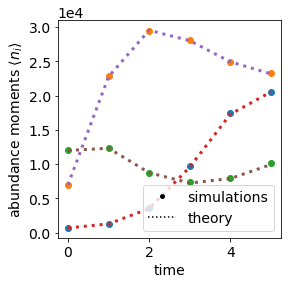

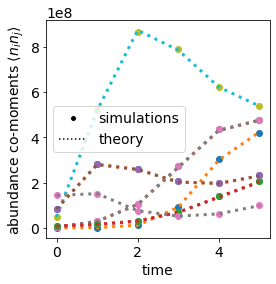

In [6]:
## Absolute abudance

sampling_times = LV_sim_par['sampling_times']

LV_data_m_k = LV_data_abs_abund['moments'][:, :n_types]
LV_data_cm_kj = LV_data_abs_abund['moments'][:, n_types:]

LV_numerics_m_k = LV_numerics_abs_abund['moments'][:, :n_types]
LV_numerics_cm_kj = LV_numerics_abs_abund['moments'][:, n_types:]

# Plot moments

mp.plot(sampling_times, LV_data_m_k, '.', markersize=12)
mp.plot(sampling_times, LV_numerics_m_k, ':', linewidth=3)
# Annotate
mp.xlabel('time', fontsize=14)
mp.ylabel(r'abundance moments $\langle n_i \rangle$', fontsize=14)
marker_sim = mlines.Line2D([0], [0], label='simulations', color='w', marker='o', markerfacecolor='k')
line_theory_abs_abund = mlines.Line2D([0], [0], label='theory', color='k', linestyle=':')
mp.legend(handles=[marker_sim, line_theory_abs_abund], fontsize=14)
mp.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
mp.show();

# Plot co-moments

for k in range(n_types**2):
    mp.plot(sampling_times, LV_data_cm_kj[:,k], '.', markersize=12)
    mp.plot(sampling_times, LV_numerics_cm_kj[:,k], ':', linewidth=3)
# Annotate
mp.xlabel('time', fontsize=14)
mp.ylabel(r'abundance co-moments $\langle n_i n_j \rangle$', fontsize=14)
marker_sim = mlines.Line2D([0], [0], label='simulations', color='w', marker='o', markerfacecolor='k')
line_theory_abs_abund = mlines.Line2D([0], [0], label='theory', color='k', linestyle=':')
mp.legend(handles=[marker_sim, line_theory_abs_abund], fontsize=14)
mp.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
mp.show();

Relative abundance

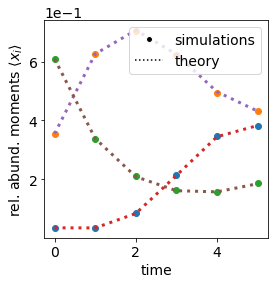

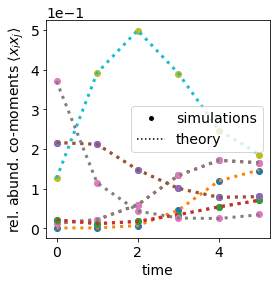

In [7]:
## Relative abundance

sampling_times = LV_sim_par['sampling_times']

LV_data_m_k = LV_data_rel_abund['moments'][:, :n_types]
LV_data_cm_kj = LV_data_rel_abund['moments'][:, n_types:]

LV_numerics_m_k = LV_numerics_rel_abund['moments'][:, :n_types]
LV_numerics_cm_kj = LV_numerics_rel_abund['moments'][:, n_types:-1]

# Plot moments

mp.plot(sampling_times, LV_data_m_k, '.', markersize=12)
mp.plot(sampling_times, LV_numerics_m_k, ':', linewidth=3)
# Annotate
mp.xlabel('time', fontsize=14)
mp.ylabel(r'rel. abund. moments $\langle x_i \rangle$', fontsize=14)
marker_sim = mlines.Line2D([0], [0], label='simulations', color='w', marker='o', markerfacecolor='k')
line_theory_abs_abund = mlines.Line2D([0], [0], label='theory', color='k', linestyle=':')
mp.legend(handles=[marker_sim, line_theory_abs_abund], fontsize=14)
mp.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
mp.show();

# Plot co-moments

for k in range(n_types**2):
    mp.plot(sampling_times, LV_data_cm_kj[:,k], '.', markersize=12)
    mp.plot(sampling_times, LV_numerics_cm_kj[:,k], ':', linewidth=3)
# Annotate
mp.xlabel('time', fontsize=14)
mp.ylabel(r'rel. abund. co-moments $\langle x_i x_j \rangle$', fontsize=14)
marker_sim = mlines.Line2D([0], [0], label='simulations', color='w', marker='o', markerfacecolor='k')
line_theory_abs_abund = mlines.Line2D([0], [0], label='theory', color='k', linestyle=':')
mp.legend(handles=[marker_sim, line_theory_abs_abund], fontsize=14)
mp.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
mp.show();

## Inference

Define the priors

In [8]:
gR_names = ["gR_%i"%i for i in range(n_types)]
I_intra_names, I_inter_names = [], []
for i in range(n_types):
    for j in range(n_types):
        if i == j: I_intra_names.append("I_%i_%i"%(i,j))
        else: I_inter_names.append("I_%i_%i"%(i,j))
mSigma_names = ["mSigma[0]"]

# Growth rates
gR_prior = n_types * [("norm", 1.5, 5E-1)]
# Intra-specific interactions
I_intra_prior = n_types * [("uniform", -1E-4, 1E-4)]
# Inter-specific interactions
I_inter_prior = (n_types**2-n_types) * [("norm", 0, 5E-5)]
# Scaling factor
mSigma_prior = [("uniform", 1.5E4, 1E4)]

parameter_names = gR_names + I_intra_names + I_inter_names + mSigma_names
priors_shapes = gR_prior + I_intra_prior + I_inter_prior + mSigma_prior
priors_dict = dict(zip(parameter_names, priors_shapes))

priors = Distribution(**{key: RV(a, b, c) for key, (a, b, c) in priors_dict.items()})

print(priors_dict)

{'gR_0': ('norm', 1.5, 0.5), 'gR_1': ('norm', 1.5, 0.5), 'gR_2': ('norm', 1.5, 0.5), 'I_0_0': ('uniform', -0.0001, 0.0001), 'I_1_1': ('uniform', -0.0001, 0.0001), 'I_2_2': ('uniform', -0.0001, 0.0001), 'I_0_1': ('norm', 0, 5e-05), 'I_0_2': ('norm', 0, 5e-05), 'I_1_0': ('norm', 0, 5e-05), 'I_1_2': ('norm', 0, 5e-05), 'I_2_0': ('norm', 0, 5e-05), 'I_2_1': ('norm', 0, 5e-05), 'mSigma[0]': ('uniform', 15000.0, 10000.0)}


"Distance" for true parameters

In [9]:
true_par_error_abs_abund = distance_abs_abund(LV_numerics_abs_abund, LV_data_abs_abund)
print('eps with true parameters (abs. abund.): %.4e'%true_par_error_abs_abund)

true_par_error_rel_abund = distance_rel_abund(LV_numerics_rel_abund, LV_data_rel_abund)
print('eps with true parameters (rel. abund.): %.4e'%true_par_error_rel_abund)

eps with true parameters (abs. abund.): 7.6328e+06
eps with true parameters (rel. abund.): 1.0762e-01


Define settings for inference

In [10]:
# Settings for inference

### For ABCSMC function

## For population size

# Number of samples in the first generation
start_nr_particles_p = 750

# CV criterion (smaller values lead to more samples per generation)
mean_cv_p = 0.4

# Number of samples from the prior to estimate the first eps
nr_calibration_particles_p = 2000

# Number of bootstrapped samples to estimate the CV of a generation
n_bootstrap_p = 2

# Minimum number of samples allowed in a generation
min_population_size_p = 500

# Maximum number of samples allowed in a generation
max_population_size_p = 1000

## For transitions

# Factor to multiply the covariance with
scaling_p = 1.

## For eps

# Initial eps (if ='from sample', eps will be calculated from the prior)
initial_epsilon_p = 'from_sample'

# Quantile for cut-off of samples within a generation (e.g. 0.1 means top 10%)
alpha_p = 0.1

# Factor to multiply the quantile with
quantile_multiplier_p = 1.

### For running ABCSMC function

## Stopping criterion: minimum eps
minimum_epsilon_abs_abund_p = 1.5 * true_par_error_abs_abund

## Stopping criterion: minimum eps
minimum_epsilon_rel_abund_p = 1.5 * true_par_error_rel_abund

## Stopping criterion: maximum number of generations
max_nr_populations_p = 30

## Stopping criterion: maximum computing time
max_walltime_p = timedelta(minutes=360)

Save settings for inference

In [11]:
with open('../data/LV/inference_parameters.pickle', 'wb') as f:
    inference_dict = {'priors_dict': priors_dict, 'start_nr_particles_p': start_nr_particles_p, 'mean_cv_p': mean_cv_p, 'nr_calibration_particles_p': nr_calibration_particles_p, 'n_bootstrap_p': n_bootstrap_p, 'min_population_size_p': min_population_size_p, 'max_population_size_p': max_population_size_p, 'scaling_p': scaling_p, 'initial_epsilon_p': initial_epsilon_p, 'alpha_p': alpha_p, 'quantile_multiplier_p': quantile_multiplier_p, 'minimum_epsilon_abs_abund_p': minimum_epsilon_abs_abund_p, 'minimum_epsilon_rel_abund_p': minimum_epsilon_rel_abund_p, 'max_nr_populations_p': max_nr_populations_p, 'max_walltime_p': max_walltime_p}
    pc.dump(inference_dict, f)
    
print(inference_dict)

{'priors_dict': {'gR_0': ('norm', 1.5, 0.5), 'gR_1': ('norm', 1.5, 0.5), 'gR_2': ('norm', 1.5, 0.5), 'I_0_0': ('uniform', -0.0001, 0.0001), 'I_1_1': ('uniform', -0.0001, 0.0001), 'I_2_2': ('uniform', -0.0001, 0.0001), 'I_0_1': ('norm', 0, 5e-05), 'I_0_2': ('norm', 0, 5e-05), 'I_1_0': ('norm', 0, 5e-05), 'I_1_2': ('norm', 0, 5e-05), 'I_2_0': ('norm', 0, 5e-05), 'I_2_1': ('norm', 0, 5e-05), 'mSigma[0]': ('uniform', 15000.0, 10000.0)}, 'start_nr_particles_p': 750, 'mean_cv_p': 0.4, 'nr_calibration_particles_p': 2000, 'n_bootstrap_p': 2, 'min_population_size_p': 500, 'max_population_size_p': 1000, 'scaling_p': 1.0, 'initial_epsilon_p': 'from_sample', 'alpha_p': 0.1, 'quantile_multiplier_p': 1.0, 'minimum_epsilon_abs_abund_p': 11449255.311668877, 'minimum_epsilon_rel_abund_p': 0.16143003792240002, 'max_nr_populations_p': 30, 'max_walltime_p': datetime.timedelta(seconds=21600)}


#### Absolute abundance

Create ABC-SMC function (consult pyABC documentation for details)

In [12]:
abc_abs_abund = ABCSMC(
    models=LV_model_abs_abund,
    parameter_priors=priors,
    distance_function=distance_abs_abund,
    population_size=AdaptivePopulationSize(start_nr_particles=start_nr_particles_p, mean_cv = mean_cv_p, nr_calibration_particles=nr_calibration_particles_p, n_bootstrap=n_bootstrap_p, min_population_size = min_population_size_p, max_population_size = max_population_size_p),
    transitions=MultivariateNormalTransition(scaling=scaling_p),
    eps=QuantileEpsilon(initial_epsilon=initial_epsilon_p, alpha=alpha_p, quantile_multiplier=quantile_multiplier_p),
)

ABC.Sampler INFO: Parallelize sampling on 24 processes.


Run ABC-SMC

In [13]:
abc_abs_abund.new(db_path_abs_abund, {"moments": LV_data_abs_abund["moments"]});

history_abs_abund = abc_abs_abund.run(minimum_epsilon = minimum_epsilon_abs_abund_p, max_nr_populations = max_nr_populations_p, max_walltime = max_walltime_p)
print('total number of simulations: %i'%history_abs_abund.total_nr_simulations)

ABC.History INFO: Start <ABCSMC id=1, start_time=2024-08-06 13:27:02>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 8.13876522e+08.
ABC INFO: Accepted: 750 / 8365 = 8.9659e-02, ESS: 7.5000e+02.
ABC.Adaptation INFO: Change nr particles 750 -> 500
ABC INFO: t: 1, eps: 3.49031144e+08.
ABC INFO: Accepted: 500 / 5904 = 8.4688e-02, ESS: 1.4811e+02.
ABC.Adaptation INFO: Change nr particles 500 -> 500
ABC INFO: t: 2, eps: 1.73049221e+08.
ABC INFO: Accepted: 500 / 8805 = 5.6786e-02, ESS: 2.7224e+02.
ABC.Adaptation INFO: Change nr particles 500 -> 500
ABC INFO: t: 3, eps: 1.07774475e+08.
ABC INFO: Accepted: 500 / 6652 = 7.5165e-02, ESS: 3.1765e+02.
ABC.Adaptation INFO: Change nr particles 500 -> 500
ABC INFO: t: 4, eps: 6.89099639e+07.
ABC INFO: Accepted: 500 / 6493 = 7.7006e-02, ESS: 3.6041e+02.
ABC.Adaptation INFO: Change nr particles 500 -> 500
ABC INFO: t: 5, eps: 4.45647636e+07.
ABC INFO: Accepted: 500 / 6858 = 7.2908e-02, ESS: 3.4904e+02.
ABC.Adaptation INFO: Change nr particle

total number of simulations: 72051


Plot posterior

In [14]:
gR_lim = n_types * [(0, 3)]
I_intra_lim = n_types * [(-1.2E-4, 0.2E-4)]
I_inter_lim = (n_types**2-n_types) * [(-2E-4, 2E-4)]
mSigma_lim = [(0., 1E5)]

limits = gR_lim + I_intra_lim + I_inter_lim + mSigma_lim
limits_dict = dict(zip(parameter_names, limits))

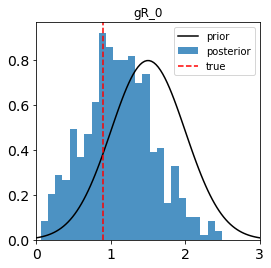

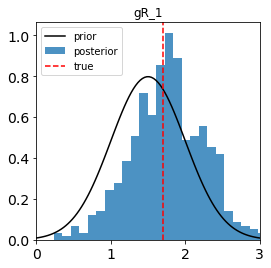

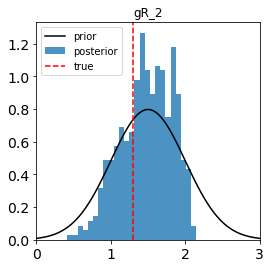

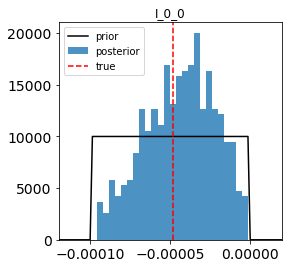

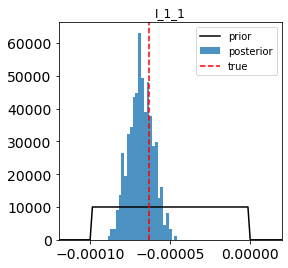

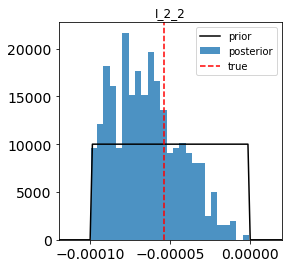

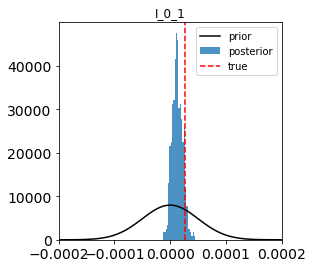

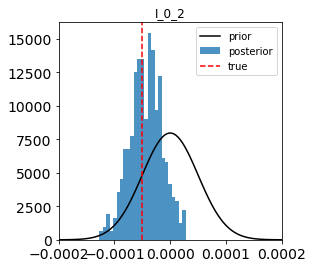

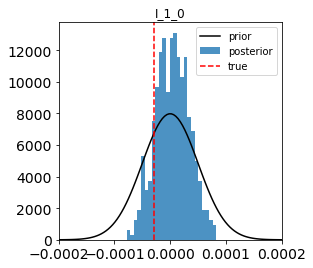

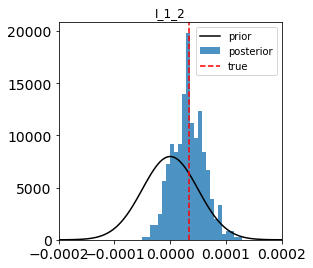

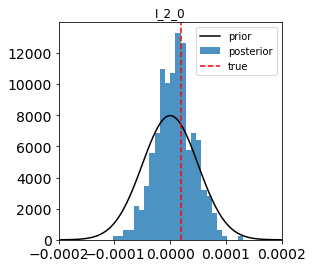

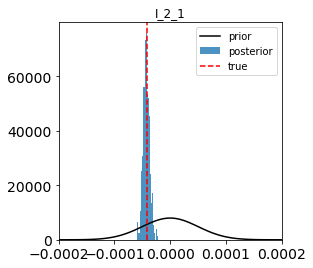

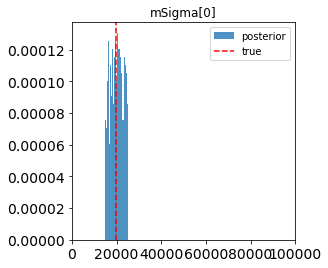

true: 		 ['gR_0' 'gR_2' 'gR_1']
posterior: 	 ['gR_0' 'gR_2' 'gR_1'] 

true: 		 ['I_1_1' 'I_2_2' 'I_0_0']
posterior: 	 ['I_1_1' 'I_2_2' 'I_0_0'] 

true: 		 ['I_0_2' 'I_2_1' 'I_1_0' 'I_2_0' 'I_0_1' 'I_1_2']
posterior: 	 ['I_0_2' 'I_2_1' 'I_1_0' 'I_2_0' 'I_0_1' 'I_1_2'] 



In [15]:
gR_mean_posterior, I_intra_mean_posterior, I_inter_mean_posterior = [], [], []

posterior_dist = history_abs_abund.get_distribution()[0]

for par in parameter_names:
    
    par_posterior = posterior_dist.loc[:,par]
    
    x = np.linspace(limits_dict[par][0], limits_dict[par][1], 100)
    
    if par in gR_names: 
        gR_mean_posterior.append(np.mean(par_posterior))
        mp.plot(x, sp.stats.norm.pdf(x, priors_dict[par][1], priors_dict[par][2]), color='k', label = 'prior')
        
    if par in I_intra_names: 
        I_intra_mean_posterior.append(np.mean(par_posterior))
        mp.plot(x, sp.stats.uniform.pdf(x, priors_dict[par][1], priors_dict[par][2]), color='k', label = 'prior')
    
    if par in I_inter_names: 
        I_inter_mean_posterior.append(np.mean(par_posterior))
        mp.plot(x, sp.stats.norm.pdf(x, priors_dict[par][1], priors_dict[par][2]), color='k', label = 'prior')
        
    mp.hist(par_posterior, density=True, bins = 25, alpha=0.8, label = 'posterior')
    mp.axvline(true_par[par], linestyle='--', color = 'r', label = 'true')
    mp.xlim(limits_dict[par])
    mp.legend()
    mp.title('%s'%par)
    mp.show()
    
print('true: \t\t', np.array(gR_names)[np.argsort(gR)])
print('posterior: \t', np.array(gR_names)[np.argsort(gR_mean_posterior)],'\n')

I_intra = I[np.eye(n_types,dtype=bool)]

print('true: \t\t', np.array(I_intra_names)[np.argsort(I_intra)])
print('posterior: \t', np.array(I_intra_names)[np.argsort(I_intra_mean_posterior)],'\n')

I_inter = I[~np.eye(n_types,dtype=bool)]

print('true: \t\t', np.array(I_inter_names)[np.argsort(I_inter)])
print('posterior: \t', np.array(I_inter_names)[np.argsort(I_inter_mean_posterior)],'\n')

In [16]:
#df, w = history_abs_abund.get_distribution(m=0, t=history_abs_abund.max_t)

#ax = plot_kde_matrix(df, w, limits=limits_dict, refval=true_par, refval_color='red')
#mp.show();

#### Relative abundance

Create ABC-SMC function (consult pyABC documentation for details)

In [17]:
abc_rel_abund = ABCSMC(
    models=LV_model_rel_abund,
    parameter_priors=priors,
    distance_function=distance_rel_abund,
    population_size=AdaptivePopulationSize(start_nr_particles=start_nr_particles_p, mean_cv = mean_cv_p, nr_calibration_particles=nr_calibration_particles_p, n_bootstrap=n_bootstrap_p, min_population_size = min_population_size_p, max_population_size = max_population_size_p),
    transitions=MultivariateNormalTransition(scaling=scaling_p),
    eps=QuantileEpsilon(initial_epsilon=initial_epsilon_p, alpha=alpha_p, quantile_multiplier=quantile_multiplier_p),
)

ABC.Sampler INFO: Parallelize sampling on 24 processes.


Run ABC-SMC

In [18]:
abc_rel_abund.new(db_path_rel_abund, {"moments": LV_data_rel_abund["moments"]});

history_rel_abund = abc_rel_abund.run(minimum_epsilon = minimum_epsilon_rel_abund_p, max_nr_populations = max_nr_populations_p, max_walltime = max_walltime_p)
print('total number of simulations: %i'%history_rel_abund.total_nr_simulations)

ABC.History INFO: Start <ABCSMC id=1, start_time=2024-08-06 13:30:10>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 1.42580192e+00.
ABC INFO: Accepted: 750 / 7698 = 9.7428e-02, ESS: 7.5000e+02.
ABC.Adaptation INFO: Change nr particles 750 -> 500
ABC INFO: t: 1, eps: 9.72564734e-01.
ABC INFO: Accepted: 500 / 6274 = 7.9694e-02, ESS: 1.9252e+02.
ABC.Adaptation INFO: Change nr particles 500 -> 500
ABC INFO: t: 2, eps: 6.90212846e-01.
ABC INFO: Accepted: 500 / 7087 = 7.0552e-02, ESS: 2.6084e+02.
ABC.Adaptation INFO: Change nr particles 500 -> 500
ABC INFO: t: 3, eps: 5.11838357e-01.
ABC INFO: Accepted: 500 / 9829 = 5.0870e-02, ESS: 3.0904e+02.
ABC.Adaptation INFO: Change nr particles 500 -> 500
ABC INFO: t: 4, eps: 3.93481884e-01.
ABC INFO: Accepted: 500 / 11343 = 4.4080e-02, ESS: 3.1022e+02.
ABC.Adaptation INFO: Change nr particles 500 -> 500
ABC INFO: t: 5, eps: 3.04038604e-01.
ABC INFO: Accepted: 500 / 16044 = 3.1164e-02, ESS: 3.5187e+02.
ABC.Adaptation INFO: Change nr partic

total number of simulations: 210298


Plot posterior

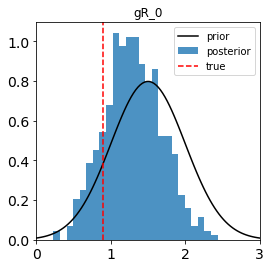

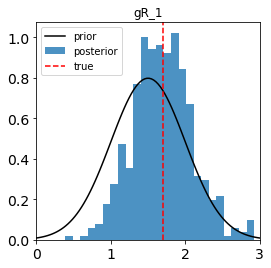

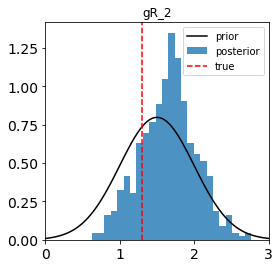

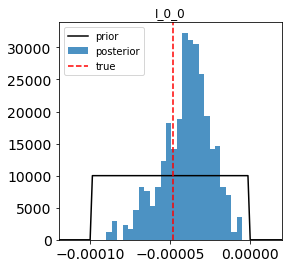

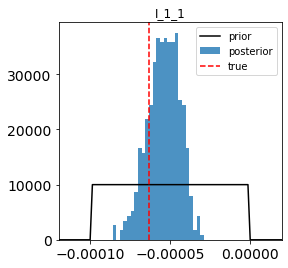

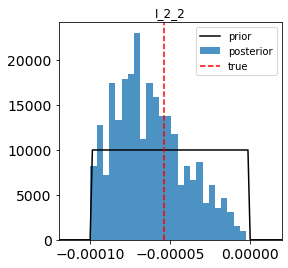

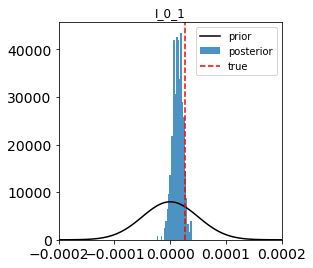

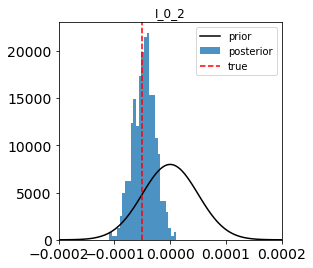

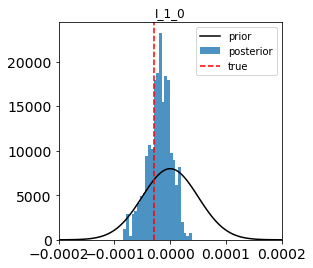

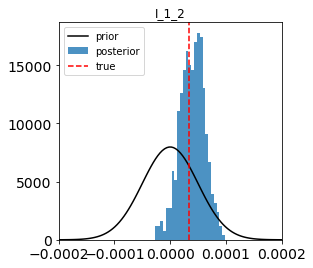

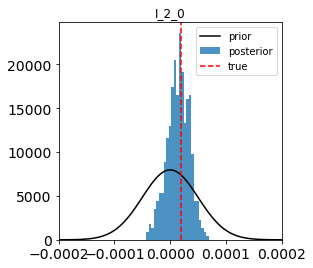

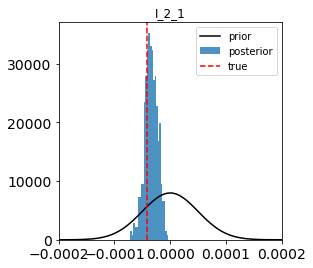

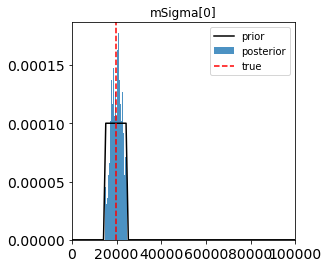

true: 		 ['gR_0' 'gR_2' 'gR_1']
posterior: 	 ['gR_0' 'gR_2' 'gR_1'] 

true: 		 ['I_1_1' 'I_2_2' 'I_0_0']
posterior: 	 ['I_2_2' 'I_1_1' 'I_0_0'] 

true: 		 ['I_0_2' 'I_2_1' 'I_1_0' 'I_2_0' 'I_0_1' 'I_1_2']
posterior: 	 ['I_0_2' 'I_2_1' 'I_1_0' 'I_0_1' 'I_2_0' 'I_1_2'] 



In [19]:
gR_mean_posterior, I_intra_mean_posterior, I_inter_mean_posterior = [], [], []

posterior_dist = history_rel_abund.get_distribution()[0]

for par in parameter_names:
    
    par_posterior = posterior_dist.loc[:,par]
    
    x = np.linspace(limits_dict[par][0], limits_dict[par][1], 100)
    
    if par in gR_names: 
        gR_mean_posterior.append(np.mean(par_posterior))
        mp.plot(x, sp.stats.norm.pdf(x, priors_dict[par][1], priors_dict[par][2]), color='k', label = 'prior')
        
    if par in I_intra_names: 
        I_intra_mean_posterior.append(np.mean(par_posterior))
        mp.plot(x, sp.stats.uniform.pdf(x, priors_dict[par][1], priors_dict[par][2]), color='k', label = 'prior')
    
    if par in I_inter_names: 
        I_inter_mean_posterior.append(np.mean(par_posterior))
        mp.plot(x, sp.stats.norm.pdf(x, priors_dict[par][1], priors_dict[par][2]), color='k', label = 'prior')
        
    if par == 'mSigma[0]':
        mp.plot(x, sp.stats.uniform.pdf(x, priors_dict[par][1], priors_dict[par][2]), color='k', label = 'prior')
        
    mp.hist(par_posterior, density=True, bins = 25, alpha=0.8, label = 'posterior')
    mp.axvline(true_par[par], linestyle='--', color = 'r', label = 'true')
    mp.xlim(limits_dict[par])
    mp.legend()
    mp.title('%s'%par)
    mp.show()
    
print('true: \t\t', np.array(gR_names)[np.argsort(gR)])
print('posterior: \t', np.array(gR_names)[np.argsort(gR_mean_posterior)],'\n')

I_intra = I[np.eye(n_types,dtype=bool)]

print('true: \t\t', np.array(I_intra_names)[np.argsort(I_intra)])
print('posterior: \t', np.array(I_intra_names)[np.argsort(I_intra_mean_posterior)],'\n')

I_inter = I[~np.eye(n_types,dtype=bool)]

print('true: \t\t', np.array(I_inter_names)[np.argsort(I_inter)])
print('posterior: \t', np.array(I_inter_names)[np.argsort(I_inter_mean_posterior)],'\n')

In [20]:
# df, w = history_rel_abund.get_distribution(m=0, t=history_rel_abund.max_t)

# ax = plot_kde_matrix(df, w, limits=limits_dict, refval=true_par, refval_color='red')
# mp.show();